In [1]:
# standard python imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
data = np.load('exp_io_data\CoupledPendula_mean_in7_out7_Tmax1.0_data.npz')
for key, val in data.items():

    exec(key +'=val')
x=xlist
y=exp_out_list
#print(y)

In [3]:
x_in=x[:,0:7]
x_para=x[:,7:14]
#print(x_in)
#print(x_para)
def pre_processing_x(x):
    n,d=x.shape
    n= int(n/2)
    d= int(d/2)
    x_in=x[:,0:d]
    x_para=x[:,d:2*d]
    x_train=x_in[0:n:]
    x_test=x_in[n:2*n,:]
    x_train_para=x_para[0:n,:]
    x_test_para=x_para[n:n*2,:]
    return x_train,x_test,x_train_para, x_test_para
a,b,c,d=pre_processing_x(x)
print(a)

[[0.24749702 0.02014035 0.8485794  ... 0.08696669 0.99749106 0.38496768]
 [0.75097805 0.60711515 0.67705935 ... 0.44351715 0.26912165 0.6546309 ]
 [0.5515969  0.85570264 0.12367398 ... 0.65876925 0.5144654  0.21687716]
 ...
 [0.7910753  0.15300226 0.25244486 ... 0.79041374 0.23180968 0.36545432]
 [0.8996175  0.3548531  0.558233   ... 0.77378803 0.30139804 0.52732176]
 [0.45920014 0.6914123  0.7981772  ... 0.7037045  0.4136985  0.35502923]]


In [4]:

y_x=y[0,:,:,:,0]
y_v=y[0,:,:,:,1]/30
print(y_x.shape)
print(y_v.shape)

y_new=np.concatenate((y_x,y_v),axis=2)
y_new=torch.from_numpy(y_new)
y_new=torch.transpose(y_new,0,1)
# print(y_new[1,1:2,:])
# print(y_new[1,2:3,:])
print(y_new.shape)




(30, 2000, 7)
(30, 2000, 7)
torch.Size([2000, 30, 14])


In [33]:

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()

        self.rnn = nn.RNN(14,14, 5,batch_first=True)
        self.fc = nn.Linear(14,14)
        
    def forward(self, x):
        out, _ =self.rnn(x)
        #out =out[:,-1,:]
        out = self.fc(out)
        return out


net2 = Net2()
print(net2)


#out0=net(in0)
#out1=net(out0)...
# full_data=30*14
# net(in5)=full_data[0:5,:]
#out0=net(in0)
#y_target=full_data[1:6,:]
#loss = mse(y_target, net(in5) )
#loss= sum (out[i]-in[i+1])


Net2(
  (rnn): RNN(14, 14, num_layers=5, batch_first=True)
  (fc): Linear(in_features=14, out_features=14, bias=True)
)


In [34]:
params = list(net2.parameters())
print(len(params))
print(params[0].size())

22
torch.Size([14, 14])


In [42]:

input = y_new[:,0:5,:]
print(input.shape)
out = net2(input)
#print(out)
print(out.shape)

torch.Size([2000, 5, 14])
torch.Size([2000, 5, 14])


In [44]:
net2.zero_grad()
out.backward(torch.randn(2000,5,14))


In [45]:
target= y_new[:,1:6,:]
print(target.shape)
criterion=nn.MSELoss()
loss=criterion(out,target)
print(loss)
print(target.shape)

torch.Size([2000, 5, 14])
tensor(0.3054, grad_fn=<MseLossBackward>)
torch.Size([2000, 5, 14])


In [47]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(20):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net2(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print(loss)


tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3053, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)
tensor(0.3052, grad_fn=<MseLossBackward>)


In [15]:
output_plot=output[:,6,:]
print(output_plot.shape)
target_plot= y_new[:,7,:]

torch.Size([2000, 14])


Text(0, 0.5, 'y_pred')

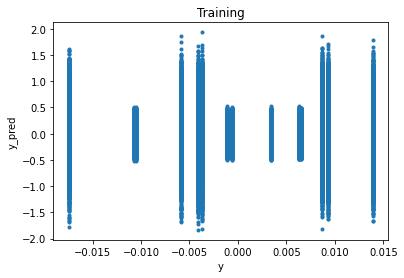

In [16]:
plt.plot(output_plot.detach().flatten(), target_plot.detach().numpy().flatten(), '.')
plt.title('Training')
plt.xlabel('y')
plt.ylabel('y_pred')

In [17]:
x_test=torch.tensor(x[1000:2000,:])
x_para_test=torch.from_numpy(x_para[1000:2000,:])
print(x_test)


tensor([[0.9185, 0.8238, 0.9963,  ..., 0.6682, 0.7984, 0.1572],
        [0.3933, 0.9606, 0.9643,  ..., 0.7520, 0.4876, 0.8830],
        [0.6237, 0.5434, 0.0358,  ..., 0.9932, 0.3677, 0.0729],
        ...,
        [0.4289, 0.7778, 0.2352,  ..., 0.7652, 0.4831, 0.2972],
        [0.2022, 0.3456, 0.6055,  ..., 0.7885, 0.4216, 0.8429],
        [0.8430, 0.8307, 0.3663,  ..., 0.3736, 0.5766, 0.7607]])


In [27]:
y_test=y_new[1000:2000,6:7,:]
print(y_test.shape)
y_test_new=torch.transpose(y_test,1,2).squeeze(2)

test_out=net2(x_test)

torch.Size([1000, 1, 14])


RuntimeError: input must have 3 dimensions, got 2

In [25]:
def plot_dt_exp_comparison(yexp, ypred):

    fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i in range(9):
        plt.sca(axs.flatten()[i])
        plt.plot(ypred[i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'digital twin prediction')
        plt.plot(yexp[i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'experimental outcome')
        plt.xlabel('# pendulum')
        plt.ylabel('output angle')
        plt.title(f'Initial conditions {i}')
        plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig('img/coupled_pendula_dt_examples.png')
    plt.show()
    
#plot_dt_exp_comparison(y_test_new,2*test_out.detach())

In [26]:
plot_dt_exp_comparison(y_test_new,2*test_out.detach())

NameError: name 'test_out' is not defined

In [32]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
print(output)

tensor([[[ 0.2375,  0.2631, -0.4102,  0.3369,  0.7218,  0.0728, -0.1361,
          -0.6703, -0.0438, -0.0732,  0.3423, -0.7693,  0.2935, -0.3053,
           0.2523, -0.0571, -0.0202,  0.2989, -0.5673,  0.5073],
         [ 0.6162,  0.1850,  0.4126,  0.7775, -0.0137, -0.0534,  0.3354,
           0.7826,  0.0203, -0.7898, -0.4899, -0.4363,  0.2901, -0.1991,
           0.8144, -0.7364, -0.2497, -0.1143,  0.2171, -0.6417],
         [-0.4599, -0.0467, -0.2275, -0.4104, -0.5177, -0.3929,  0.2770,
           0.8107,  0.1556, -0.0995, -0.1703, -0.8356, -0.2047,  0.1082,
          -0.4893, -0.3708,  0.2517, -0.5033,  0.1679, -0.7449]],

        [[ 0.5826, -0.2345, -0.1166, -0.1942, -0.4757,  0.3322, -0.5826,
          -0.3270,  0.2118, -0.0024, -0.1701, -0.6327,  0.2515,  0.1649,
          -0.0095, -0.0376, -0.2996, -0.0382, -0.7207, -0.1265],
         [-0.0549, -0.0493,  0.2682,  0.3365, -0.1387,  0.2228, -0.3334,
           0.1602, -0.3064, -0.0831,  0.2582, -0.5007,  0.0114, -0.0103,
        

params2 = list(net2.parameters())
print(len(params2))
print(params2[0].size())

In [ ]:
x_data=torch.tensor(x)
input = x_data
out = net2(input)
print(out)
print(out.shape)

In [ ]:
target=y1[0:1000,:,:]
target_new=target.view(1000,7)

In [ ]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net2(input)
    loss = criterion(output, target_new)
    loss.backward()
    optimizer.step()
    print(loss)
